In [1]:
from IPython.display import display, HTML
display(HTML("""
<style>
div.container{width:86% !important;}
div.cell.code_cell.rendered{width:100%;}
div.CodeMirror {font-family:Consolas; font-size:12pt;}
div.output {font-size:15pt; font-weight:bold;}
div.input {font-family:Consolas; font-size:12pt;}
div.prompt {min-width:70px;}
div#toc-wrapper{padding-top:120px;}
div.text_cell_render ul li{font-size:12pt;padding:5px;}
table.dataframe{font-size:15px;}
</style>
"""))

In [44]:
import numpy as np
import pandas as pd
import sys
from tensorflow.keras import utils # utils.to_categorical 원핫인코딩
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout
from matplotlib import pyplot as plt

# 로지스틱 회귀분석(이진분류)

## 1. 데이터셋 생성 & 전처리

In [3]:
df = pd.read_csv('data/pima-indians-diabetes.csv',
                 comment='#',
                 header=None)
df.info() # 결측치 없음

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       768 non-null    int64  
 1   1       768 non-null    int64  
 2   2       768 non-null    int64  
 3   3       768 non-null    int64  
 4   4       768 non-null    int64  
 5   5       768 non-null    float64
 6   6       768 non-null    float64
 7   7       768 non-null    int64  
 8   8       768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [4]:
# 타겟 변수의 균형
df.iloc[:, -1].value_counts()

0    500
1    268
Name: 8, dtype: int64

In [5]:
df.head()

,0,1,2,3,4,5,6,7,8
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [6]:
# csv 파일을 numpy 로 읽어오기 : np.loadtxt(결측치 없을 경우), np.genfromtxt(결측치 있을 경우)
dataset = np.loadtxt('data/pima-indians-diabetes.csv',
                     encoding='utf-8',
                     delimiter=',')
dataset.shape

(768, 9)

In [7]:
# 데이터 분할 : 학습데이터셋(모델학습용) + 시험데이터셋(모델평가용)
X_train = dataset[:700, :-1]
y_train = dataset[:700, -1]
X_test = dataset[700:,:-1]
y_test = dataset[700:, -1]
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((700, 8), (700,), (68, 8), (68,))

## 2. 모델 구성

In [8]:
model = Sequential()
model.add(Input(shape=(8,)))
model.add(Dense(units=32, activation='relu')) # Dense 층 쌓음 -> DNN
model.add(Dense(units=16, activation='relu'))
model.add(Dense(units=1,  activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                288       
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 833
Trainable params: 833
Non-trainable params: 0
_________________________________________________________________


## 3. 학습과정 설정

In [9]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['binary_accuracy'])

## 4. 학습

In [10]:
%%time
hist = model.fit(X_train, y_train, # 훈련데이터
                 epochs=200, # 학습횟수
                 batch_size=350, # 한 번에 읽어들이는 데이터 양
#                  validation_data=(X_test, y_test), # 검증데이터
#                  validation_split=0.1,
                 verbose = 0 # 학습 로그 출력(0:출력X , 1: 출력O, 2: 출력 자세히)
                )

CPU times: total: 1.59 s
Wall time: 1.16 s


## 5. 모델 평가(학습과정 보기, 평가)

In [11]:
hist.history.keys()

dict_keys(['loss', 'binary_accuracy'])

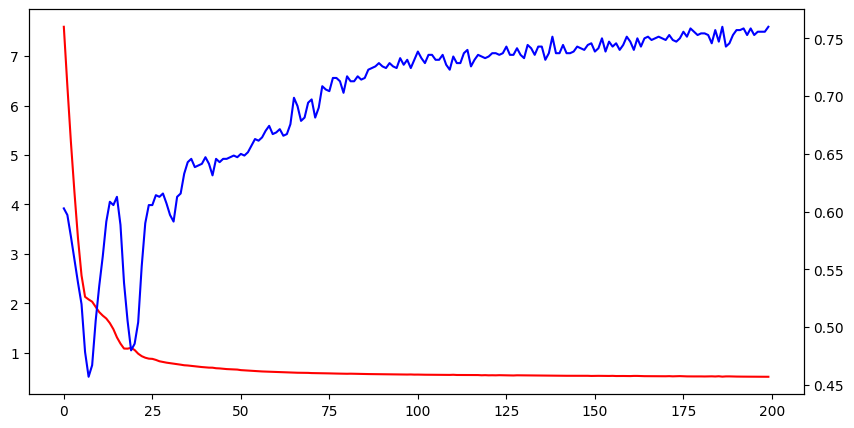

In [12]:
# 학습과정 표시(학습데이터에 대한 loss와 accuracy)
fig, loss_ax = plt.subplots(figsize=(10, 5))
loss_ax.plot(hist.history['loss'], 'r')
acc_ax = loss_ax.twinx() # loss_ax와 x축을 공유하는 acc_ax
acc_ax.plot(hist.history.get('binary_accuracy'), 'b')

In [13]:
# 모델 평가(X)
model.evaluate(X_train, y_train)

22/22 [==============================] - 0s 2ms/step - loss: 0.5138 - binary_accuracy: 0.7614


[0.5137681365013123, 0.7614285945892334]

In [14]:
# 모델 평가(O)
model.evaluate(X_test, y_test)

3/3 [==============================] - 0s 2ms/step - loss: 0.6906 - binary_accuracy: 0.6618


[0.6905550956726074, 0.6617646813392639]

## 혼동행렬
- 테스트 데이터셋의 실제값과 예측값으로 작성된 교차표

In [15]:
y_test[:5]

array([0., 1., 1., 0., 0.])

In [16]:
# 실제값 : y_test (68개)
# 예측값
y_hat = (model.predict(X_test)>=0.5).astype(float)

3/3 [==============================] - 0s 2ms/step


In [17]:
TN = 0 # 0을 0으로 예측한 경우의 수 - T
FP = 0 # 0을 1로 예측한 경우의 수(틀린 경우) - F
FN = 0 # 1을 0으로 예측한 경우의 수 - F
TP = 0 # 1을 1로 예측한 경우의 수 - T
print(y_test.shape, y_hat.shape)
for y, h in zip(y_test, y_hat.reshape(-1)) :
    if y==0 and h==0 :
        TN += 1
    elif y==0 and h==1:
        FP += 1
    elif y==1 and h==0:
        FN += 1
    else :
        TP += 1
print(TN, FP)
print(FN, TP)

(68,) (68, 1)
35 6
17 10


In [18]:
ctab = pd.crosstab(y_test, # 실제값
                   y_hat.reshape(-1)) # 예측값
ctab.index.name = '실제값'
ctab.columns.name = '예측값'
ctab
pd.crosstab(y_test, # 실제값
            y_hat.reshape(-1),
            rownames=['실제값'],
            colnames=['예측값']) # 예측값

예측값,0.0,1.0
실제값,,
0.0,35,6
1.0,17,10


In [19]:
# 혼동행렬
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test,
                 y_hat.reshape(-1))

array([[35,  6],
       [17, 10]], dtype=int64)

In [20]:
# accuracy
print('accuracy : ', (TN+TP)/(TN+FP+FN+TP))
print('recall : ', (TP) / (FN+TP))
print('precision : ', (TP)/(FP+TP))

accuracy :  0.6617647058823529
recall :  0.37037037037037035
precision :  0.625


## 6. 모델 사용

In [21]:
X_test[1]

array([  6.   , 125.   ,  78.   ,  31.   ,   0.   ,  27.6  ,   0.565,
        49.   ])

In [22]:
int(model.predict(np.array([[2, 122, 76, 27, 200, 35.9, 0.483, 26]]))>=0.5)

1/1 [==============================] - 0s 20ms/step


0

In [23]:
model.predict([[2, 122, 76, 27, 200, 35.9, 0.483, 26],
              ])

1/1 [==============================] - 0s 41ms/step


array([[0.3022341]], dtype=float32)

# 분류분석
1. 데이터셋 생성 및 전처리 : 훈련셋(600), 검증셋(100), 테스트셋(68)
2. 모델 생성(input 8, output 2) : 출력층 softmax(출력합을 1)
    * model.summary() 파라미터 수와 메모리 확인
3. 모델 학습과정 설정 : loss="categorical_crossentropy, metrics=["accuracy"]
4. 모델 학습 : 훈련셋과 검증셋
5. 모델 평가 : 그래프(hist.history), 평가(테스트셋), 교차표(테스트셋)
6. 모델 사용 : predict 결과에 argmax()
[99.2, 0.8]

In [24]:
dataset = np.loadtxt('data/pima-indians-diabetes.csv',
                     encoding='utf-8',
                     delimiter=',')
dataset.shape

(768, 9)

In [25]:
# 훈련셋(600), 검증셋(100), 테스트셋(68)
X_train = dataset[:600, :-1]
y_train = dataset[:600, -1]
X_val = dataset[600:700, :-1]
y_val = dataset[600:700, -1]
X_test = dataset[700:, :-1]
y_test = dataset[700:, -1]
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((600, 8), (600,), (100, 8), (100,), (68, 8), (68,))

In [26]:
# 타겟변수의 원핫인코딩(분류분석)
print(y_train[:5])
print(utils.to_categorical(y_train[:5]))
Y_train = utils.to_categorical(y_train)
Y_val   = utils.to_categorical(y_val)
Y_test  = utils.to_categorical(y_test)
y_train.shape, Y_train.shape, Y_val.shape, Y_test.shape

[1. 0. 1. 0. 1.]
[[0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]]


((600,), (600, 2), (100, 2), (68, 2))

# 2. 모델 생성(input8, target2)
 - 과적합 줄이는 단계 추가(dropout 추가)

In [45]:
model = Sequential()
model.add(Input(shape=(8,)))
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.2)) # 과적합 해결
model.add(Dense(units=64, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(units=16, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=8, activation='relu'))
model.add(Dense(units=2, activation='softmax'))
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_17 (Dense)            (None, 32)                288       
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_18 (Dense)            (None, 64)                2112      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_19 (Dense)            (None, 16)                1040      
                                                                 
 dropout_2 (Dropout)         (None, 16)                0         
                                                                 
 dense_20 (Dense)            (None, 8)                

# 3. 학습과정 설정

In [46]:
model.compile(loss='categorical_crossentropy',
              optimizer='nadam',
              metrics=['accuracy'])

# 4. 모델 학습

In [47]:
hist = model.fit(X_train, Y_train,
                 epochs=300,
                 validation_data=(X_val, Y_val),
                 verbose=1, batch_size=100)

Epoch 1/300
6/6 [==============================] - 1s 33ms/step - loss: 4.1145 - accuracy: 0.5950 - val_loss: 1.1440 - val_accuracy: 0.5100
Epoch 2/300
6/6 [==============================] - 0s 8ms/step - loss: 2.5333 - accuracy: 0.5683 - val_loss: 1.8608 - val_accuracy: 0.3900
Epoch 3/300
6/6 [==============================] - 0s 7ms/step - loss: 2.0203 - accuracy: 0.5567 - val_loss: 1.5553 - val_accuracy: 0.3300
Epoch 4/300
6/6 [==============================] - 0s 10ms/step - loss: 1.9133 - accuracy: 0.5333 - val_loss: 1.0965 - val_accuracy: 0.3800
Epoch 5/300
6/6 [==============================] - 0s 8ms/step - loss: 1.5487 - accuracy: 0.5300 - val_loss: 0.9095 - val_accuracy: 0.4400
Epoch 6/300
6/6 [==============================] - 0s 8ms/step - loss: 1.4258 - accuracy: 0.5933 - val_loss: 0.8865 - val_accuracy: 0.5100
Epoch 7/300
6/6 [==============================] - 0s 8ms/step - loss: 1.2388 - accuracy: 0.5583 - val_loss: 0.8231 - val_accuracy: 0.4700
Epoch 8/300
6/6 [========

6/6 [==============================] - 0s 8ms/step - loss: 0.5930 - accuracy: 0.6883 - val_loss: 0.5893 - val_accuracy: 0.6800
Epoch 118/300
6/6 [==============================] - 0s 9ms/step - loss: 0.5913 - accuracy: 0.6750 - val_loss: 0.5895 - val_accuracy: 0.6800
Epoch 119/300
6/6 [==============================] - 0s 7ms/step - loss: 0.6018 - accuracy: 0.6883 - val_loss: 0.5888 - val_accuracy: 0.6900
Epoch 120/300
6/6 [==============================] - 0s 8ms/step - loss: 0.6031 - accuracy: 0.6933 - val_loss: 0.5863 - val_accuracy: 0.6900
Epoch 121/300
6/6 [==============================] - 0s 8ms/step - loss: 0.5961 - accuracy: 0.6917 - val_loss: 0.5858 - val_accuracy: 0.6900
Epoch 122/300
6/6 [==============================] - 0s 8ms/step - loss: 0.6049 - accuracy: 0.7017 - val_loss: 0.5857 - val_accuracy: 0.6800
Epoch 123/300
6/6 [==============================] - 0s 7ms/step - loss: 0.5911 - accuracy: 0.6767 - val_loss: 0.5843 - val_accuracy: 0.6900
Epoch 124/300
6/6 [========

6/6 [==============================] - 0s 8ms/step - loss: 0.5618 - accuracy: 0.7283 - val_loss: 0.5735 - val_accuracy: 0.7000
Epoch 234/300
6/6 [==============================] - 0s 7ms/step - loss: 0.5652 - accuracy: 0.7100 - val_loss: 0.5731 - val_accuracy: 0.7200
Epoch 235/300
6/6 [==============================] - 0s 8ms/step - loss: 0.5754 - accuracy: 0.7150 - val_loss: 0.5760 - val_accuracy: 0.7000
Epoch 236/300
6/6 [==============================] - 0s 7ms/step - loss: 0.5796 - accuracy: 0.7033 - val_loss: 0.5772 - val_accuracy: 0.6900
Epoch 237/300
6/6 [==============================] - 0s 8ms/step - loss: 0.5756 - accuracy: 0.6950 - val_loss: 0.5777 - val_accuracy: 0.6900
Epoch 238/300
6/6 [==============================] - 0s 8ms/step - loss: 0.5642 - accuracy: 0.6950 - val_loss: 0.5769 - val_accuracy: 0.6800
Epoch 239/300
6/6 [==============================] - 0s 8ms/step - loss: 0.5605 - accuracy: 0.7233 - val_loss: 0.5764 - val_accuracy: 0.6800
Epoch 240/300
6/6 [========

# 5. 학습과정 살펴보기

In [48]:
hist.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

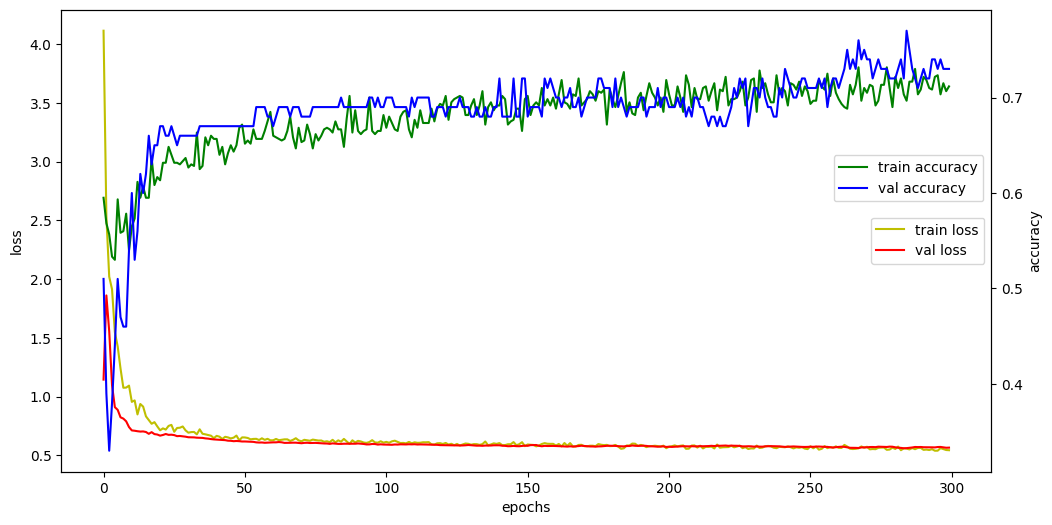

In [56]:
fig, loss_ax = plt.subplots(figsize=(12, 6))
loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
acc_ax = loss_ax.twinx()
acc_ax.plot(hist.history['accuracy'], 'g', label='train accuracy')
acc_ax.plot(hist.history['val_accuracy'], 'b', label='val accuracy')
loss_ax.set_xlabel('epochs')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')
loss_ax.legend(loc='center right')
acc_ax.legend(bbox_to_anchor=(0.999, 0.7))
plt.show()

# 6. 모델 평가 & 교차표

In [58]:
loss, accuracy = model.evaluate(X_test, Y_test, verbose=0)
print(f"loss : {loss}, 정확도 : {accuracy}")

loss : 0.6004616022109985, 정확도 : 0.6617646813392639


In [61]:
# 교차표
y_test

array([0., 1., 1., 0., 0., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 1., 1.,
       0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0.,
       0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0., 1., 1., 1.,
       0., 0., 1., 1., 1., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0.])

In [63]:
y_hat = model.predict(X_test).argmax(axis=1)
y_hat

3/3 [==============================] - 0s 2ms/step


array([0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0], dtype=int64)

In [64]:
pd.crosstab(y_test, y_hat, rownames=['실제값'], colnames=['예측값'])

예측값,0,1
실제값,,
0.0,40,1
1.0,22,5


In [65]:
confusion_matrix(y_test, y_hat)

array([[40,  1],
       [22,  5]], dtype=int64)

# 7. 모델 저장 및 사용

In [66]:
from tensorflow.keras.models import save_model, load_model
# model.sae('model/06_pima.h5')
save_model(model, 'model/06_pima.h5')

In [67]:
model2 = load_model('model/06_pima.h5')

In [71]:
pred = model2.predict([[2, 122, 76, 27, 200, 35.9, 0.483, 26],
                [6, 125, 78, 31, 0, 27.6, 0.565, 49]])
pred.argmax(axis=1)

1/1 [==============================] - 0s 40ms/step


array([0, 0], dtype=int64)

In [72]:
np.argmax(pred, axis=1)

array([0, 0], dtype=int64)